In [14]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time
import gc
import pathlib

In [15]:
save_plots = True

## Create plots directory, if missing
plotsDirectory = '/home/adegenna/vertex-reconstruction-studies/plots/reco_efficiency/'
pathlib.Path(plotsDirectory).mkdir(parents=True, exist_ok=True)

# Import Monte Carlo data

In [2]:
inputMC = '~/data/LHCbMC_2016-2017-2018_MagUpDown_Lb2JPsiL_Ttracks_v12.h5'

In [3]:
tick = time.perf_counter()
df_MC_reco = pd.read_hdf(inputMC, key='LHCbMC_Lb')
tock = time.perf_counter()
print(f"Monte Carlo imported in {tock - tick:0.4f} seconds.")

Monte Carlo imported in 2.2138 seconds.


In [4]:
tick = time.perf_counter()
df_MC_truth = pd.read_hdf(inputMC, key='LHCbMCTruth_Lb')
tock = time.perf_counter()
print(f"Monte Carlo Truth imported in {tock - tick:0.4f} seconds.")

Monte Carlo Truth imported in 21.3776 seconds.


In [5]:
tick = time.perf_counter()
df_MC = pd.merge(df_MC_truth, df_MC_reco.loc[df_MC_reco['MC_key'] >= 0, :].drop('TrackType', axis='columns').groupby('MC_key').first(), how='left', on='MC_key')
tock = time.perf_counter()
print(f"Monte Carlo merged in {tock - tick:0.4f} seconds.")

Monte Carlo merged in 164.5212 seconds.


In [6]:
## Cut on true Lambda decay vertex. 8000 is the maximum to have events,
## no Lambda in the MC decays farther than that.
LambdaZVertexLowerBound = 5500
LambdaZVertexUpperBound = 8000
df_MC = df_MC[(df_MC['MCTRUTH_L_ENDVERTEX_Z'] > LambdaZVertexLowerBound) & (df_MC['MCTRUTH_L_ENDVERTEX_Z'] < LambdaZVertexUpperBound)]
df_MC

,MCTRUTH_Lb_ENDVERTEX_X,MCTRUTH_Lb_ENDVERTEX_Y,MCTRUTH_Lb_ENDVERTEX_Z,MCTRUTH_L_ENDVERTEX_X,MCTRUTH_L_ENDVERTEX_Y,MCTRUTH_L_ENDVERTEX_Z,MCTRUTH_p_PX,MCTRUTH_p_PY,MCTRUTH_p_PZ,MCTRUTH_pim_PX,...,DTF_FixJPsiLambda_PIDSubs_pim_PZ,DTF_FixJPsiLambda_PIDSubs_p_PX,DTF_FixJPsiLambda_PIDSubs_p_PY,DTF_FixJPsiLambda_PIDSubs_p_PZ,DTF_FixJPsiLambda_PIDSubs_mum_PX,DTF_FixJPsiLambda_PIDSubs_mum_PY,DTF_FixJPsiLambda_PIDSubs_mum_PZ,DTF_FixJPsiLambda_PIDSubs_mup_PX,DTF_FixJPsiLambda_PIDSubs_mup_PY,DTF_FixJPsiLambda_PIDSubs_mup_PZ
MC_key,,,,,,,,,,,,,,,,,,,,,
29,0.8237,-0.2123,3.514200,140.238602,325.837311,7463.102539,367.250000,1035.959961,24602.169922,174.279999,...,25203.607422,171.069519,222.666214,4137.976074,-605.608093,594.454895,11170.495117,71.893692,-2873.631348,73489.484375
68,0.6988,0.1457,8.921400,-275.270508,517.665710,6044.109863,-1734.800049,3088.909912,36901.781250,-165.570007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,0.1737,-0.2302,6.356200,-30.531700,-311.828491,7045.362305,-97.980003,-924.580017,18892.099609,5.040000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,0.5991,-0.2019,37.328098,-31.441000,-262.683105,7216.815430,-199.880005,-1420.540039,36778.171875,-6.320000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,0.9935,-0.9283,-16.168501,-34.232498,-338.234802,7619.163086,-252.279999,-2650.100098,61709.449219,-106.110001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8921753,0.9233,0.1671,9.821300,65.648102,114.385803,6598.966797,795.969971,1589.550049,88814.687500,283.649994,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8921755,0.8836,0.1212,12.387000,185.393295,-125.622803,7188.478516,1751.500000,-1272.150024,71170.023438,553.190002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8921777,1.2719,0.2954,1.781700,220.534607,180.934799,7350.403809,2247.919922,1818.459961,75455.960938,707.440002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
## Cleanup
del(df_MC_truth)
del(df_MC_reco)
gc.collect()

36

# Study the reconstruction efficiency
We focus on $\Lambda$ and $\Lambda_b$ reconstruction efficiencies because, as we'll see, they are unusually low.

In [8]:
## Select reconstructed muons. There is a very small (~4500) number of reconstructed events
## where the 'PID_Reconstructed' variables do not match the corresponding 'PID_Reconstructible'.
reconstructibleMuons = (df_MC['mum_Reconstructible']=='ChargedLong') & (df_MC['mup_Reconstructible']=='ChargedLong')
reconstructedMuons = (df_MC['mum_Reconstructed']=='ChargedLong') & (df_MC['mup_Reconstructed']=='ChargedLong')

## The mismatched events here are a bit more (~11k). I suppose this could be because of particles
## potentially reconstructible as something "better" than TTRACKS (e.g. LONG) that get a degreaded result.
reconstructibleTTracks = (df_MC['pim_Reconstructible']=='ChargedTtrack') & (df_MC['p_Reconstructible']=='ChargedTtrack')
reconstructedTTracks = (df_MC['pim_Reconstructed']=='ChargedTtrack') & (df_MC['p_Reconstructed']=='ChargedTtrack')

## This selects all events actually reconstructed in the MC_reco. Since we have constrained reconstruction
## of muons, protons and pions, the deficit must be due to Lambda and/or Lambdab reconstrution failure.
## (Or J/psi, sure, but we assume that two LONG muons are tracked much better than two TTRACKS proton and pions.)
allReconstructedEvents = ((df_MC['Rec_key'] >= 0) & (df_MC['TrackType'] == 'T'))

In [9]:
selectionCandidates = (
    reconstructibleMuons & reconstructedMuons
    & reconstructibleTTracks & reconstructedTTracks
)
    
selectionPassed = selectionCandidates & allReconstructedEvents

In [10]:
selectionCandidates

MC_key
29          True
68         False
79         False
89         False
102        False
           ...  
8921753    False
8921755    False
8921777    False
8921803    False
8921805     True
Length: 467699, dtype: bool

In [11]:
binning = np.linspace(5500, 8000, 25)
LambdaZTrueDecayVertices = df_MC['MCTRUTH_L_ENDVERTEX_Z']

binnedCandidates, _ = np.histogram(LambdaZTrueDecayVertices[selectionCandidates], bins=binning)
binnedPassed, _ = np.histogram(LambdaZTrueDecayVertices[selectionPassed], bins=binning)

binnedEfficiencies = binnedPassed / binnedCandidates

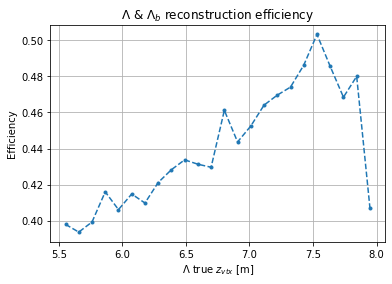

In [16]:
binningMidpoints = (binning[1:] + binning[:-1]) / 2

plt.plot(binningMidpoints/1000, binnedEfficiencies, color='tab:blue', linestyle='--', marker='.')
plt.xlabel("$\Lambda$ true $z_{vtx}$ [m]")
plt.ylabel("Efficiency")
plt.title("$\Lambda$ & $\Lambda_b$ reconstruction efficiency")
plt.grid()
if save_plots:
    plt.savefig(plotsDirectory + 'lambda_lambdab_reco_efficiency.pdf', bbox_inches='tight')
plt.show()